**Scenario A**

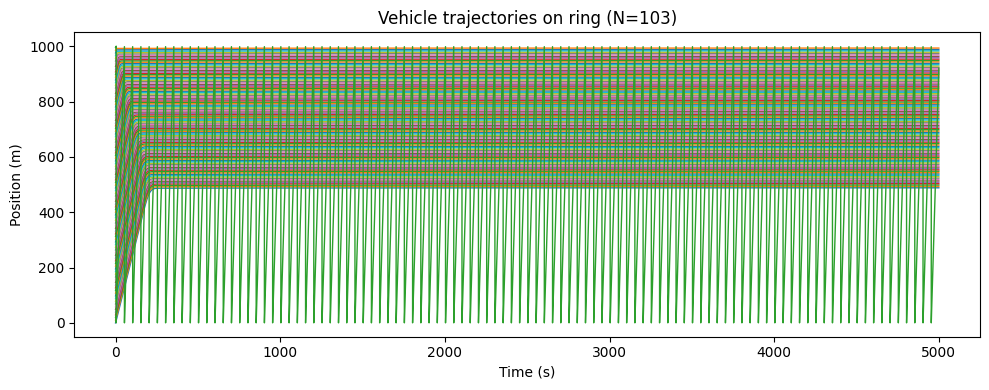

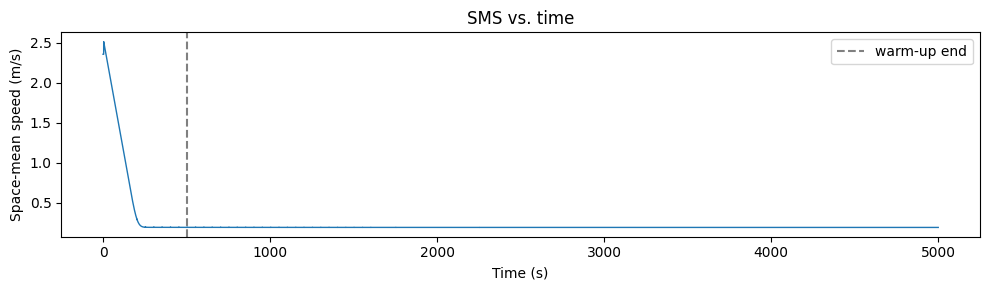

Steady SMS ≈ 0.19 m/s, density = 0.103 veh/m, flow ≈ 0.020 veh/s


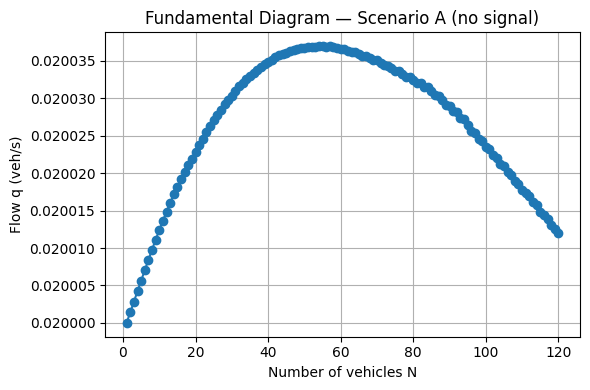

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model parameters (§B) ---
tau       = 2.0    # desired time gap (s)
L_vehicle = 5.0    # vehicle length (m)
dt        = 0.1    # time step (s)
v_f       = 20.0   # free‑flow speed (m/s)

# --- Ring settings (no signal) ---
L_road   = 1000.0  # ring length (m)
T_total  = 5000.0  # total simulation time (s)
warmup   = 500.0   # discard first 500 s for steady‐state

def simulate(N, T=T_total):
    """
    Simulate N vehicles on a signal‑free ring.
    Returns:
      traj: (n_steps × N) array of positions over time
      SMS:  (n_steps,)   array of space‐mean speeds
    """
    n_steps = int(T / dt)
    # initialize equally‐spaced vehicles
    x    = np.linspace(0, L_road - L_vehicle, N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        traj[t] = x.copy()
        # gap to leader (with wrap)
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        # clamp negative gaps
        gaps = np.maximum(gaps, 0.0)
        # Newell’s speed
        v = np.minimum(gaps / tau, v_f)
        # update positions
        x = (x + v * dt) % L_road
        # record space‐mean speed
        SMS[t] = v.mean()

    return traj, SMS

def main():
    # Prompt user for N0 between 1 and 120
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            else:
                print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    # Run simulation for that N0
    traj, SMS = simulate(N0)
    times = np.arange(len(SMS)) * dt

    # a) Time–space trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Vehicle trajectories on ring (N={N0})')
    plt.tight_layout()
    plt.show()

    # b) SMS vs. time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, lw=1)
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute and print steady‐state SMS & flow for N0
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road        # veh/m
    flow0        = density0 * steady_sms  # veh/s
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # --- 2) Fundamental Diagram (N=1…120) ---
    Ns    = np.arange(1, 121)       # number of vehicles
    flows = np.zeros_like(Ns, dtype=float)
    for idx, N in enumerate(Ns):
        _, SMS_k = simulate(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        k = N / L_road
        flows[idx] = k * steady_sms_k

    plt.figure(figsize=(6, 4))
    plt.plot(Ns, flows, 'o-')
    plt.xlabel('Number of vehicles N')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Fundamental Diagram — Scenario A (no signal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



**Scenario B**

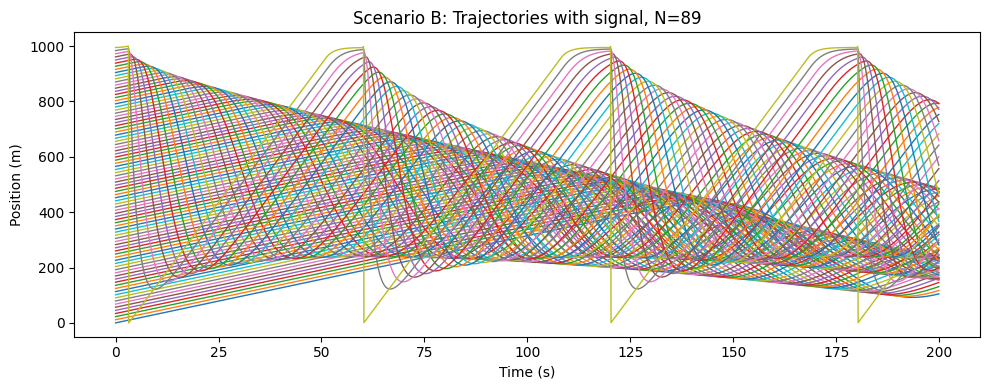

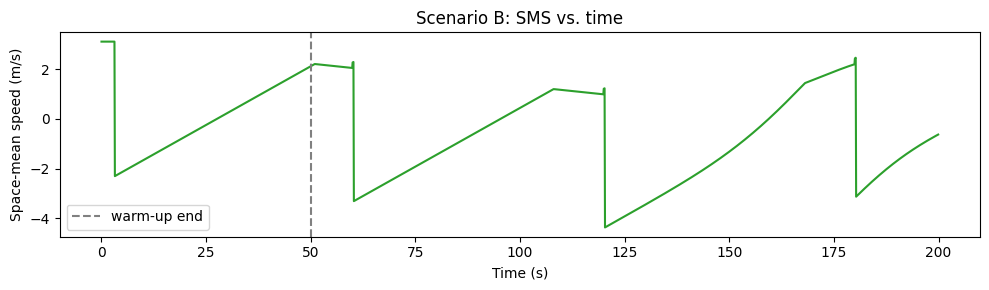

Steady SMS ≈ -0.76 m/s, density = 0.089 veh/m, flow ≈ -0.068 veh/s


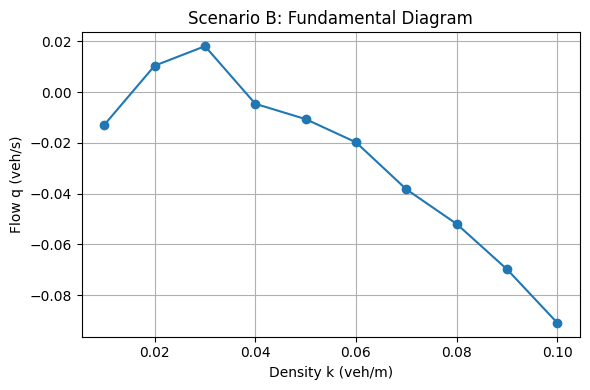

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model parameters (from §B) ---
tau       = 2.0    # desired time gap (s)
L_vehicle = 5.0    # vehicle length (m)
dt        = 0.1    # time step (s)
v_f       = 20.0   # free‑flow speed (m/s)

# --- Road & signal settings ---
L_road   = 1000.0  # ring length (m)
T_total  = 200.0   # sim duration (s)
warmup   = 50.0    # discard first 50 s
x_signal = 0.0     # signal at x=0
T_cycle  = 60.0    # cycle length (s)
g        = 0.5     # green ratio

def simulate_signal(N):
    """
    Simulate N vehicles on a ring with one traffic signal.
    Returns traj (n_steps×N) and SMS (n_steps,).
    """
    n_steps = int(T_total / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    v = np.zeros(N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        time = t * dt
        phase = time % T_cycle
        is_green = phase < (g * T_cycle)

        traj[t] = x.copy()

        # gap to vehicle ahead
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road

        # if red, cap by distance to stop line
        if not is_green:
            d_signal = (x_signal - x - L_vehicle) % L_road
            gaps = np.minimum(gaps, d_signal)

        # Newell’s rule
        v = np.minimum(gaps / tau, v_f)

        # move & wrap
        x = (x + v * dt) % L_road

        SMS[t] = v.mean()

    return traj, SMS

def main():
    # — Prompt user for N0 in [1,120] —
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    # Run for that N0
    traj, SMS = simulate_signal(N0)
    times = np.arange(len(SMS)) * dt

    # a) Trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Scenario B: Trajectories with signal, N={N0}')
    plt.tight_layout()
    plt.show()

    # b) SMS vs. time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, color='tab:green')
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('Scenario B: SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute steady‐state SMS & flow
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road
    flow0        = density0 * steady_sms
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # Fundamental diagram sweep (clamp max N to 120)
    densities = np.linspace(0.01, 0.1, 10)
    flows      = []
    for k in densities:
        N = min(120, max(1, int(k * L_road)))
        _, SMS_k = simulate_signal(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows.append(k * steady_sms_k)

    plt.figure(figsize=(6, 4))
    plt.plot(densities, flows, 'o-', color='tab:blue')
    plt.xlabel('Density k (veh/m)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Scenario B: Fundamental Diagram')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


**Scenario B - change of FD with the green light ratio**

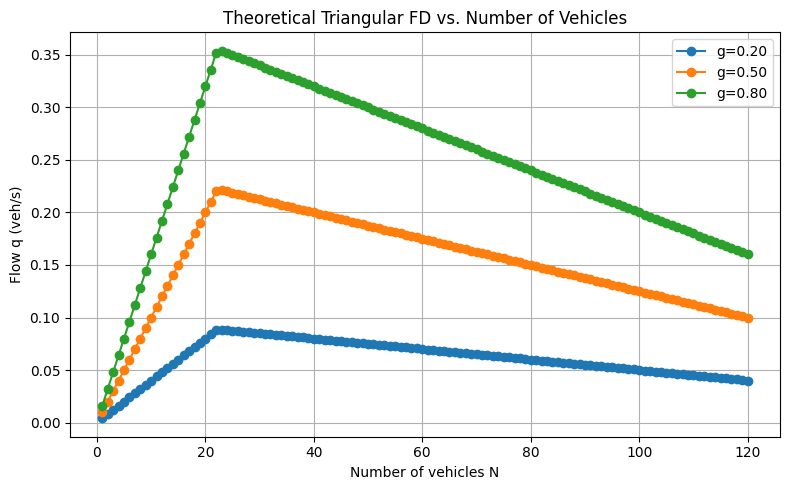

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
v_f = 20.0             # free-flow speed (m/s)
tau = 2.0              # time gap (s)
L_vehicle = 5.0        # vehicle length (m)
k_j = 1 / L_vehicle    # jam density (veh/m)
w = L_vehicle / tau    # backward wave speed (m/s)
L_road = 1000.0        # ring length (m)

# Number of vehicles from 1 to 120
Ns = np.arange(1, 121)
densities = Ns / L_road  # veh/m

# Different green ratios to compare
green_ratios = [0.2, 0.5, 0.8]

plt.figure(figsize=(8, 5))
for g in green_ratios:
    # Theoretical triangular FD scaled by green ratio g
    flows = g * np.minimum(v_f * densities, w * (k_j - densities))
    plt.plot(Ns, flows, 'o-', label=f'g={g:.2f}')

plt.xlabel('Number of vehicles N')
plt.ylabel('Flow q (veh/s)')
plt.title('Theoretical Triangular FD vs. Number of Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


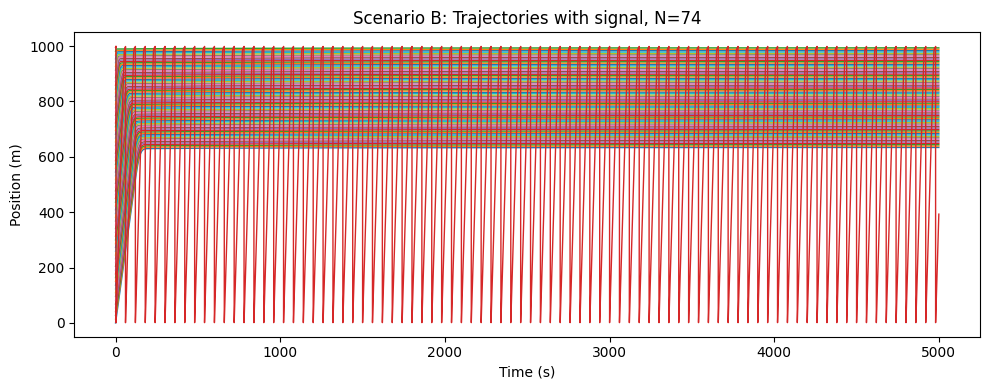

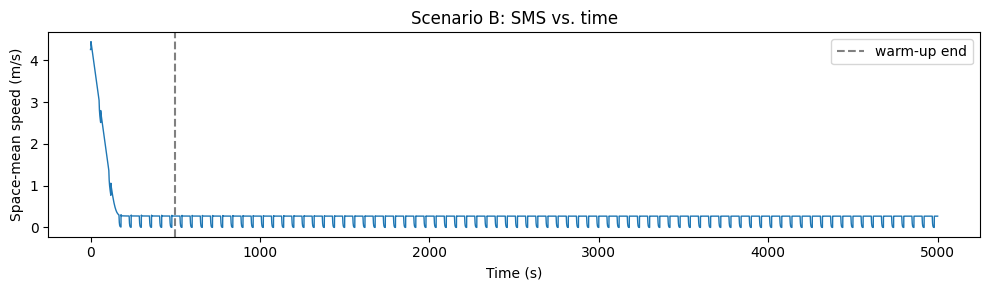

Steady SMS ≈ 0.23 m/s, density = 0.074 veh/m, flow ≈ 0.017 veh/s


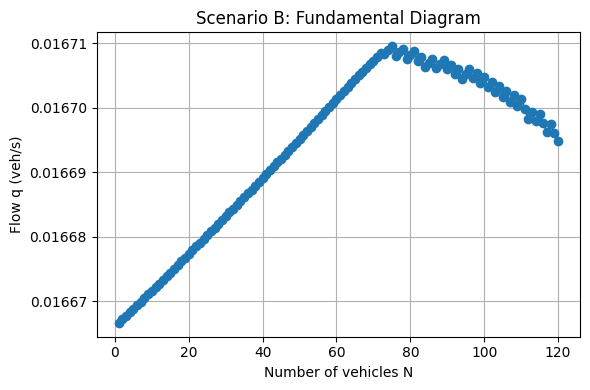

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model parameters (§B) ---
tau       = 2.0    # desired time gap (s)
L_vehicle = 5.0    # vehicle length (m)
dt        = 0.1    # time step (s)
v_f       = 20.0   # free‑flow speed (m/s)

# --- Ring & signal settings (Scenario B) ---
L_road   = 1000.0  # ring length (m)
T_total  = 5000.0  # total simulation time (s)
warmup   = 500.0   # discard first 500 s for steady‐state
T_cycle  = 60.0    # signal cycle length (s)
g        = 0.5     # green ratio (30 s green / 60 s cycle)

def simulate_signal(N, T=T_total):
    """
    Simulate N vehicles on a ring with a traffic signal.
    Returns:
      traj: (n_steps × N) array of positions over time
      SMS:  (n_steps,)   array of space‐mean speeds
    """
    n_steps = int(T / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        traj[t] = x.copy()
        # Determine signal state
        phase    = (t * dt) % T_cycle
        is_green = (phase < g * T_cycle)

        # Compute gaps to the vehicle ahead
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        gaps = np.maximum(gaps, 0.0)  # clamp negative gaps

        # During red, cap gaps by distance to stop line at x=0
        if not is_green:
            d_signal = (L_road - x - L_vehicle) % L_road
            gaps = np.minimum(gaps, d_signal)

        # Newell’s speed update
        v = np.minimum(gaps / tau, v_f)
        # Position update with periodic boundary
        x = (x + v * dt) % L_road
        # Record space‐mean speed
        SMS[t] = v.mean()

    return traj, SMS

def main():
    # Prompt for number of vehicles
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    # Run simulation for N0
    traj, SMS = simulate_signal(N0)
    times = np.arange(len(SMS)) * dt

    # a) Plot time–space trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Scenario B: Trajectories with signal, N={N0}')
    plt.tight_layout()
    plt.show()

    # b) Plot SMS vs. time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, lw=1)
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('Scenario B: SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute steady‐state SMS and flow
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road
    flow0        = density0 * steady_sms
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # c) Fundamental diagram sweep (N=1…120)
    Ns    = np.arange(1, 121)
    flows = np.zeros_like(Ns, dtype=float)
    for idx, N in enumerate(Ns):
        _, SMS_k = simulate_signal(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows[idx] = (N / L_road) * steady_sms_k

    plt.figure(figsize=(6, 4))
    plt.plot(Ns, flows, 'o-')
    plt.xlabel('Number of vehicles N')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Scenario B: Fundamental Diagram')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
